# CollectedNextDispatch Example
This notebook shows how to use the ORCA.CollectedNextDispatch object in an optimization workflow. The yaml file `CollectedNextDispatchExample.yaml` located in the `notebooks` directory is used to specify all the required parameters to use CollectedNextDispatch. Details about the system modeled are given below:

## Nuclear Power Plant
$ q_{NPP} $ - Capacity (MW)

## Electric Energy Storage
$ S_{max} $ - Energy Capacity (MWh)

$ q_{max}^D, q_{max}^C $ - maximum power for discharge/charge (MW)

$ \gamma_{RTE} $ - round trip efficiency (%)

## State of Charge

$$ S_t = S_{t-1} + \left(\sqrt{\gamma_{RTE}} q_{t-1}^C - \frac{q_{t-1}^D}{\sqrt{\gamma_{RTE}}}\right)\Delta t \times \frac{1 hr}{60 min}$$ 

where

$ \Delta t $ is the time difference (5 minutes)

## Objective Function

$$ \max \sum_{t=1}^T P_t\left(q_{NPP} - q_t^C + q_t^D\right) $$ 

where

$ P_t $ is the real time LMP

$ q_{NPP} $ is the total capacity of the NPP (MW)

$ q_t^D $ is the power discharged from the electric energy storage to the real time market (MW)

$ q_t^C $ is the power dispatched to the electric energy storage for charging (MW)

## Constraints

$$ \begin{align}
0 \leq S_t &\leq S_{max} \\
0 \leq q_t^D &\leq q_{max}^D \\
0 \leq q_t^C &\leq q_{max}^C \\
0 \leq q_t^D &\leq \sqrt{\gamma_{RTE}}S_{t}\frac{60}{\Delta t} + \gamma_{RTE}q_{t}^C
\end{align} $$

## Simplified Model
The model used in this notebook is a simplified state space model of the above as:

$$ x_{t} = A x_{t-1} + B u_t $$

where

$$ \begin{align}
x_t &= \begin{bmatrix} q_{NPP} \\ S_t \end{bmatrix} \\
u_t &= \begin{bmatrix} q_t^C \\ q_t^D \end{bmatrix}
\end{align}$$

Matrices $A$ and $B$ were determined from a simulation using 5 minute LMP data from PJM and the following values:

$$ \begin{align}
t_{window} &= 60*12 \, (minutes) \\
dt &= 5 \, (minutes) \\
q_{NPP} &= 50.0 \, (MW) \\
S_{max} &= 20.0 \, (MWh) \\
q_{max}^D &= 20.0 \, (MW) \\
q_{max}^C &= 20.0 \, (MW) \\
\gamma_{RTE} &= 0.8 \\
S_{init} &= 0.0
\end{align}$$

## Imports

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
from tests.data.SamplePKLFile import generate_matrices_pkl_from_csv
from ORCA.CollectedNextDispatch import CollectedNextDispatch

## Generate A, B, C matrices pickle file

In [2]:
generate_matrices_pkl_from_csv()

## Look at Historical Data File

In [3]:
history_df = pd.read_csv('../tests/data/storage_data.csv')
history_df['time'] = pd.to_datetime(history_df['time'])

In [4]:
history_df.head()

,Unnamed: 0,time,qNPP,qRT,qD,qC,SOC,SOC2,LMP
0,0,2022-05-31 00:05:00,50,50.0,0.0,0.0,0.0,0.0,53.454072
1,1,2022-05-31 00:10:00,50,50.0,0.0,0.0,0.0,0.0,53.958779
2,2,2022-05-31 00:15:00,50,50.0,0.0,0.0,0.0,0.0,52.616717
3,3,2022-05-31 00:20:00,50,50.0,0.0,0.0,0.0,0.0,55.741934
4,4,2022-05-31 00:25:00,50,50.0,0.0,0.0,0.0,0.0,65.632971


<IPython.core.display.Javascript object>


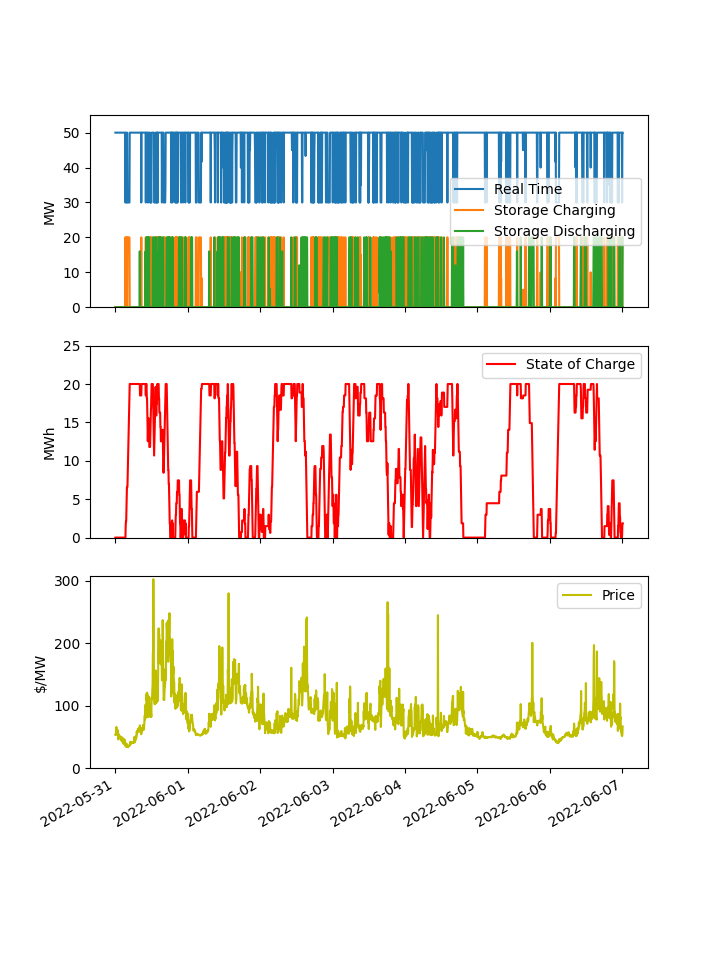

In [5]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(7.2, 9.6))
ax[0].plot(history_df['time'], history_df['qRT'], label='Real Time')
ax[0].plot(history_df['time'], history_df['qC'], label='Storage Charging')
ax[0].plot(history_df['time'], history_df['qD'], label='Storage Discharging')
ax[0].set_ylim(bottom=0, top=50.0+5)
ax[0].set_ylabel('MW')
ax[0].legend(loc=5)
ax[1].plot(history_df['time'], history_df['SOC'], 'r', label='State of Charge')
ax[1].set_ylim(bottom=0, top=20+5)
ax[1].set_ylabel('MWh')
ax[1].legend()
ax[2].plot(history_df['time'], history_df['LMP'], 'y', label='Price')
ax[2].set_ylim(bottom=0, top=history_df['LMP'].max()+5)
ax[2].set_ylabel('$/MW')
ax[2].legend()
fig.autofmt_xdate()

## Set up a Workflow

In [6]:
# create a CollectedNextDispatch object
obj = CollectedNextDispatch('CollectedNextDispatchExample.yaml')

# specify an initial and end time
initial_time = pd.to_datetime('2022-05-31 04:00:00')
end_time = pd.to_datetime('2022-06-06 00:05:00')
current_time = initial_time

# initial states
x_init = [50.0, 0.0]

# run workflow
while current_time < end_time:
    result = obj.return_optimal_next_dispatch(current_time, x_init)
    # update initial states and current time
    x_init = result['states']
    current_time += pd.Timedelta(minutes=5)

## Look at Results

<IPython.core.display.Javascript object>


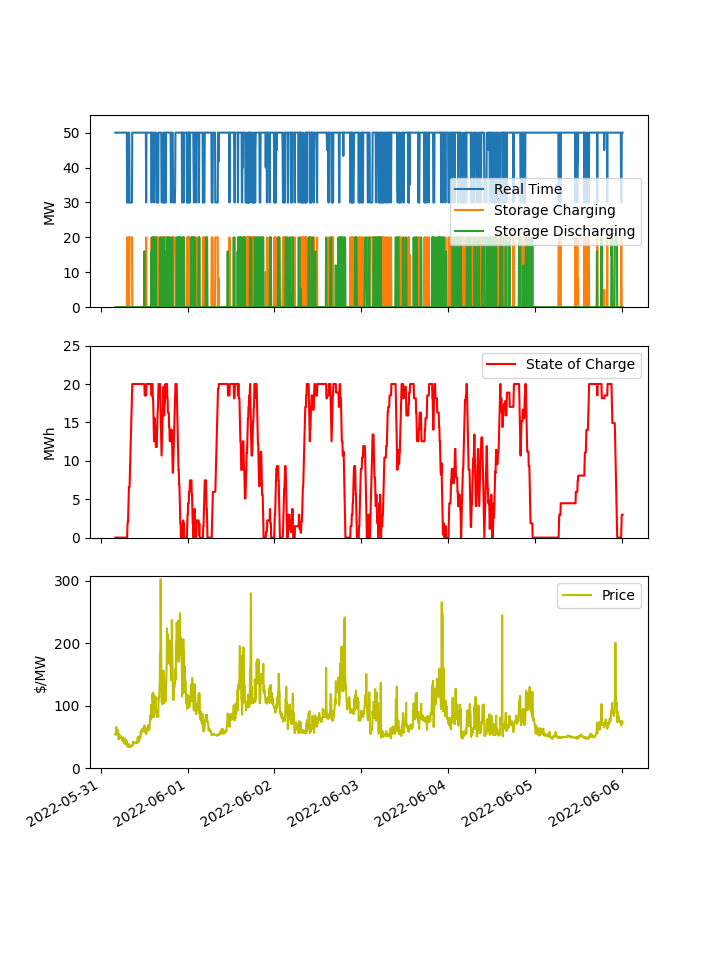

In [7]:
# pull results dataframe from CollectedNextDispatch object
result_df = obj.optimal_results
result_df = result_df.rename(columns={'price': 'LMP'})
result_df['qRT'] = result_df['qNPP'] - result_df['qC']

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(7.2, 9.6))
ax[0].plot(result_df['Time'], result_df['qRT'], label='Real Time')
ax[0].plot(result_df['Time'], result_df['qC'], label='Storage Charging')
ax[0].plot(result_df['Time'], result_df['qD'], label='Storage Discharging')
ax[0].set_ylim(bottom=0, top=50.0+5)
ax[0].set_ylabel('MW')
ax[0].legend(loc=5)
ax[1].plot(result_df['Time'], result_df['SOC'], 'r', label='State of Charge')
ax[1].set_ylim(bottom=0, top=20+5)
ax[1].set_ylabel('MWh')
ax[1].legend()
ax[2].plot(result_df['Time'], result_df['LMP'], 'y', label='Price')
ax[2].set_ylim(bottom=0, top=result_df['LMP'].max()+5)
ax[2].set_ylabel('$/MW')
ax[2].legend()
fig.autofmt_xdate()